In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import re
nlp = spacy.load("en_core_web_sm")
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_auc_score

df_fake_news = pd.read_csv("Fake.csv")
df_true_news = pd.read_csv("True.csv")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abdurrazaq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [150]:
df_fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [151]:
df_fake_news["subject"].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [236]:
#Create a category whether a news is fake or not
df_fake_news["category"]=0
df_true_news["category"]=1

#Combine both dataset
df = pd.concat([df_fake_news, df_true_news]).reset_index(drop=True)
df["category"].value_counts()

A centerpiece of Donald Trump s campaign, and now his presidency, has been his white supremacist ways. That is why so many of the public feuds he gets into involve people of color. One of his favorite targets, is, of course, the players in the National Football League who dare to exercise their First Amendment rights by kneeling during the national anthem in protest of racist police brutality. Well, there is one person who has figured out that racism is bad for business, even if it did get the orange overlord elected: The founder of the pizza chain Papa John s.This is a man who has never been on the right side of history on any number of issues, and plus his pizza sucks. But, when he decided to complain about the players protesting, his sales really dropped. Turns out racism doesn t pay, and we all know that corporations are all about the bottom line. Therefore, Papa John Schnatter will no longer be CEO of the hack pizza chain.BREAKING: Papa John's founder John Schnatter to step down a

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


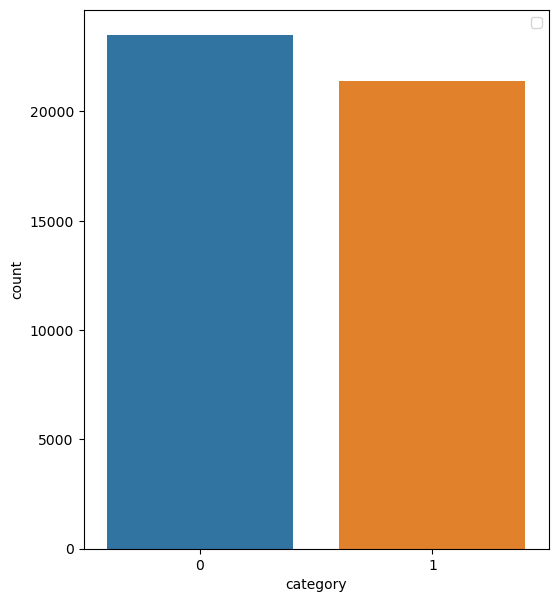

In [153]:
#setting the figure size
plt.figure(figsize=(6,7))
sns.countplot(x="category", data=df)
plt.legend()

<Axes: xlabel='subject', ylabel='count'>

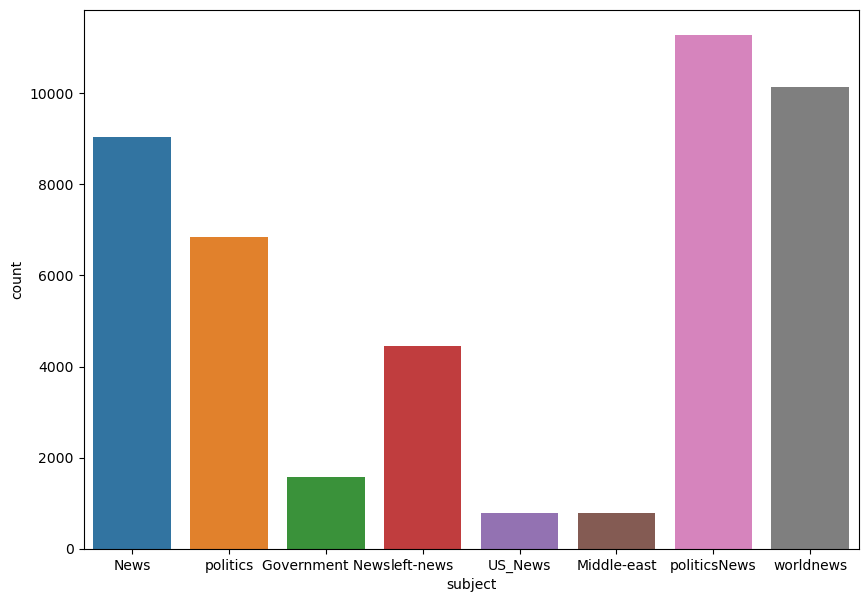

In [154]:
plt.figure(figsize=(10,7))
sns.countplot(x="subject", data=df)

In [155]:
df = df[["text","category"]]
df.tail()

,text,category
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,1
44897,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,1


In [156]:
#Clean the data
df.isnull().sum()*100/(len(df))

text        0.0
category    0.0
dtype: float64

In [157]:
#Get rows with empty string of text, df.i
#blanks = df[df["text"].str.strip() == ""]
blanks = []

for index, text in df["text"].items():
    if text.isspace():
        blanks.append(index)
len(blanks)


631

In [158]:
df.shape

(44898, 2)

In [159]:
df.drop(blanks, inplace=True)
df.shape

(44267, 2)

In [244]:
#combine both spacy and nltk
stopwords_combined = set((set(nlp.Defaults.stop_words)| set(stopwords.words("english"))))

#text cleaning function
def sanitize_text(text):
    
    string = ""
    
    #lower casing
    text=text.lower()
        
    #simplifying text
    text=re.sub(r"i'm","i am",text)
    text=re.sub(r"he's","he is",text)
    text=re.sub(r"she's","she is",text)
    text=re.sub(r"that's","that is",text)
    text=re.sub(r"what's","what is",text)
    text=re.sub(r"where's","where is",text)
    text=re.sub(r"\'ll"," will",text)
    text=re.sub(r"\'ve"," have",text)
    text=re.sub(r"\'re"," are",text)
    text=re.sub(r"\'d"," would",text)
    text=re.sub(r"won't","will not",text)
    text=re.sub(r"can't","cannot",text)
    
    #removing any special character
    text=re.sub(r"[-()\"#!@$%^&*{}?.,:]"," ",text)
    text=re.sub(r"\s+"," ",text)
    text=re.sub('[^A-Za-z0-9]+',' ', text)
    
    for word in text.split():
        if word not in stopwords_combine:
            string+=lemma.lemmatize(word)+" "
    
    return string

clean_text = sanitize_text(df["text"][0][:100])
print(clean_text)
print(df["text"][0][:100])

donald trump wish american happy new year leave instead 
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had


In [245]:
df["text"] = df["text"].apply(sanitize_text)
df["text"].head()

0    donald trump wish american happy new year leav...
1    house intelligence committee chairman devin nu...
2    friday revealed milwaukee sheriff david clarke...
3    christmas day donald trump announced work foll...
4    pope francis annual christmas day message rebu...
Name: text, dtype: object

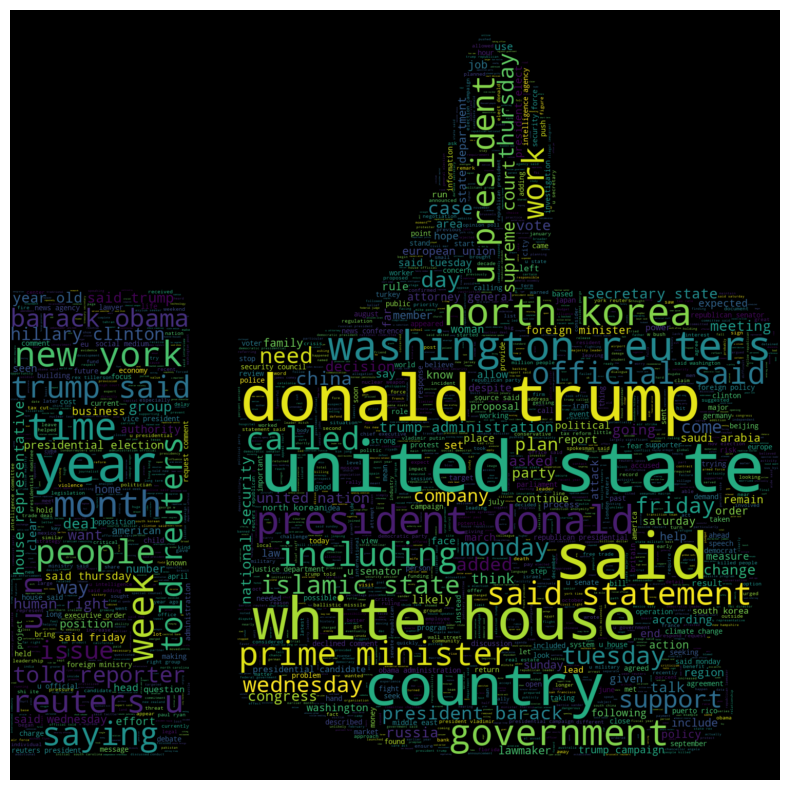

In [163]:
#True News with wordcloud
icon = Image.open("imgs/thumbsup2.png")
mask=Image.new(mode="RGB",size=icon.size, color=(255,255,255))
mask.paste(icon, box=icon)
rgb_array=np.array(mask)

wc = WordCloud(background_color="black", mask=rgb_array, max_words=2000, width=1600, height=800)

# Join and feed text
text_input = " ".join(df[df.category == 1].text)
wc.generate(text_input)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

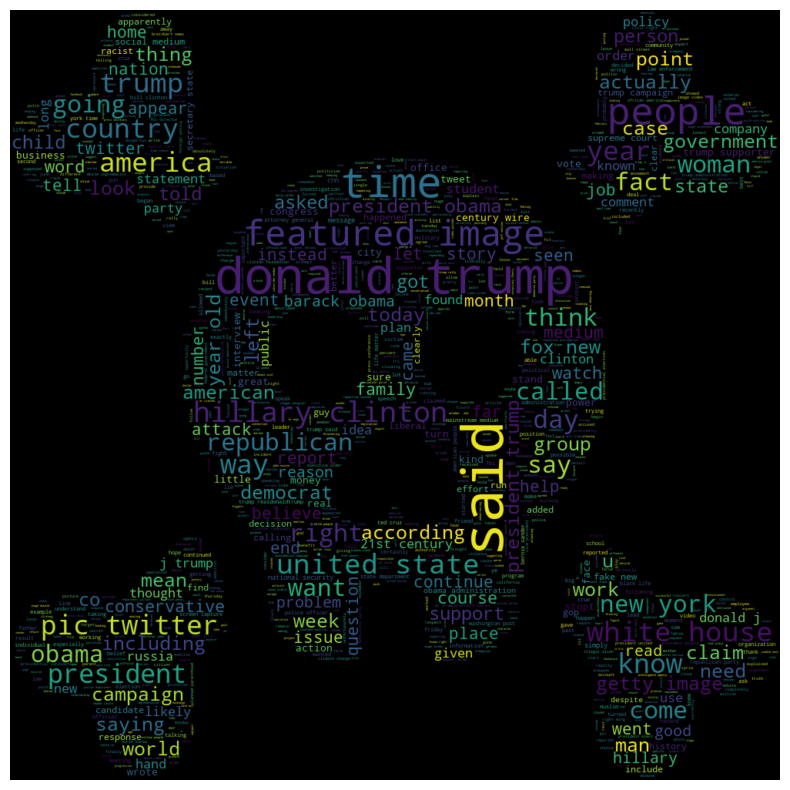

In [164]:
#Fake News

skull_image = "imgs/skull2.png"
icon = Image.open(skull_image)
mask = Image.new(mode="RGB", size=icon.size, color=(255,255,255))
mask.paste(icon, box=icon)

rgb_array= np.array(mask)

plt.figure(figsize=(10,10))
wc = WordCloud(background_color="black", mask=rgb_array, max_words=2000, width = 1600, 
               height = 800)
wc.generate(" ".join(df[df.category == 0].text))
plt.axis("off")
plt.imshow(wc, interpolation = "bilinear")

In [165]:
def calculate_percentage(part, total):
    if total == 0:
        return 0
    return (part / total) * 100


#split the data
x= df["text"] #feature (predictors)
y= df["category"] #labels (target)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print(
    f"Predictors size: {x_train.shape[0]} ({calculate_percentage(x_train.shape[0], x.shape[0]):.2f}%) for train, "
    f"{x_test.shape[0]} ({calculate_percentage(x_test.shape[0], x.shape[0]):.2f}%) for test"
)

print(
    f"Target size: {y_train.shape[0]} ({calculate_percentage(y_train.shape[0], x.shape[0]):.2f}%) for train, "
    f"{y_test.shape[0]} ({calculate_percentage(X_test.shape[0], x.shape[0]):.2f}%) for test"
)


Predictors size: 35413 (80.00%) for train, 8854 (20.00%) for test
Target size: 35413 (80.00%) for train, 8854 (20.00%) for test


In [166]:
#TFIDF Vectorizer

vectorizer =TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(x_train)


In [167]:
x_train_tfidf

<35413x102964 sparse matrix of type '<class 'numpy.float64'>'
	with 5279845 stored elements in Compressed Sparse Row format>

In [168]:
#Model Building
classifier = LinearSVC(dual=True)
classifier.fit(x_train_tfidf, y_train)

LinearSVC(dual=True)

In [174]:
text_classifier = Pipeline([("tfidf", TfidfVectorizer()), ("clf", LinearSVC(dual=True))])
text_classifier.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC(dual=True))])

<h1>#Model Evaluation</h1>

In [180]:
predictions = text_classifier.predict(x_test)

In [183]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4585
           1       0.99      0.99      0.99      4269

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



In [181]:
print(metrics.accuracy_score(y_test, predictions))

0.9942398915744296


In [182]:
print(metrics.confusion_matrix(y_test, predictions))

[[4558   27]
 [  24 4245]]
